# Twitter customer care dataset

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
import spacy
nlp = spacy.load("en_core_web_sm")
from spacymoji import Emoji
emoji = Emoji(nlp)
# nlp.add_pipe(emoji, first=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import os
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
os.chdir('/Users/tdentry/repos/vonage')
os.listdir('kaggle_customer_support') # ('kaggle_customer_support/')

['twcs2.csv', '.DS_Store', 'twcs.csv', 'sample.csv', 'twcs.csv.zip']

# The goal of this exercise:
1. Parse the data set into similarly themed conversational interactions (to what our Care organization might see with customers)
2. Evaluate the dataset with two different models (transformer and NLTK.vader), both of which are unsupervised transfer learning models for sentiment - with the goal of seeing how much the models concur


### create dataframe with dataset consisting of customer support tweets

In [3]:
tweets = pd.read_csv('kaggle_customer_support/twcs.csv')

In [4]:
tweets.shape

(2811774, 7)

In [5]:
tweets.head(10) # Evaluate the dataset

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,@115713 This is saddening to hear. Please shoo...,NaN,12.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,@115713 We understand your concerns and we'd l...,12,16.0


In [6]:
# Evaluate some data to understand the type of text inside of the cell
tweets.iloc[8]['text']

'@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯'

### I am going to focus on the customer tweets only for this experiment 

In [7]:
customer_view = tweets[tweets.inbound]

In [8]:
customer_view.shape

(1537843, 7)

###  to isolate the dataset further, I am choosing to initially focus on a telecommunications sub dataset

In [9]:
customer = customer_view[customer_view['text'].str.contains("@sprintcare")]

In [10]:
customer.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0


In [11]:
### Keep the size of the dataset large so we have ample training and test data

In [12]:
result = customer.dtypes

In [13]:
result

tweet_id                     int64
author_id                   object
inbound                       bool
created_at                  object
text                        object
response_tweet_id           object
in_response_to_tweet_id    float64
dtype: object

In [14]:
customer['created_at'] = pd.to_datetime(customer.created_at)
customer= customer.sort_values(by = 'created_at')

/var/folders/pl/k80fpf9s4f9_3rp8hnpw5x0m0000gq/T/ipykernel_18056/1001897530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer['created_at'] = pd.to_datetime(customer.created_at)


In [15]:
customer.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1157188,1278330,419157,True,2011-11-28 18:39:16+00:00,@sprintcare I can not make any calls whats the...,1278329,NaN
1402575,1544038,478295,True,2015-09-16 02:57:20+00:00,@115714 @sprintcare I get almost no service af...,"1544039,1544040,1544041,1544035",NaN
2582572,2753722,770395,True,2015-10-26 17:07:32+00:00,@sprintcare to replace this one without paying...,2753721,2753723.0
2582570,2753720,770395,True,2015-10-26 17:14:03+00:00,@sprintcare done,2753719,2753721.0
2582569,2753719,770395,True,2015-10-26 17:30:32+00:00,@sprintcare get any early upgrade. My less th...,2753718,2753720.0


#### in order to normalize the data for later use in transformer comparison, I am going to:
- remove @sprintcare
- remove frequent words
- remove stopwords
- remove URLs

In [16]:
# 1. Get the most frequent terms
counter = Counter()
for text in customer["text"].values:
    for word in text.split():
        counter[word] +=1
top_25 = counter.most_common(25)
top_25_list = [tup[0] for tup in top_25]
top_25_list = [word for word in top_25_list if word != 'not']

# print(top_25_list)

# 2. Get the least frequent terms
Y = customer['text']
vectorizer = CountVectorizer(min_df = 2)
matrix = vectorizer.fit_transform(Y)
counts = pd.DataFrame(matrix.toarray(), columns = vectorizer.get_feature_names_out())
stop_w = list(vectorizer.stop_words_)
print('not' in stop_w)
all_stops = stop_w + top_25_list


# print(all_stops)

False


In [17]:
n_rare_words = 25
rare_words = set([w for (w,c) in counter.most_common()][:- n_rare_words: -1])
print(rare_words)

{'100000', '🤙🏽', 'this).', '#payingabillandgettingnothinginreturn', '888-211-4727', '28557', '#reset.', '#threeweeks', 'https://t.co/XXFAQShfFw', "Hasn't", "I'm#stilldealingwith.", 'Fashooo!', '#happenedagainwhiletweeting', 'Left', 'mistakes,', 'later....', 'suggestion,', '$320', 'ago!!!', 'store?!?', '#nopestillnodata', 'mins!!', '$160.', 'performed'}


#### The Twitter dataset has many @something, #something, and URLs. We need to remove them.


In [18]:
customer.reset_index(drop=True, inplace = True)

In [19]:
def clean_twitter(tweet):
    clean_tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
    clean_tweet = re.sub("#[A-Za-z0-9_]+","", clean_tweet)
    words = clean_tweet.split()
    words = ' '.join([w for w in words if w not in all_stops])
    return words

customer['clean'] = customer['text'].progress_apply(lambda tweet: clean_twitter(tweet))

  0%|          | 0/13711 [00:00<?, ?it/s]

In [20]:
customer.head(7)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,clean
0,1278330,419157,True,2011-11-28 18:39:16+00:00,@sprintcare I can not make any calls whats the...,1278329,NaN,can not make any calls whats problem please le...
1,1544038,478295,True,2015-09-16 02:57:20+00:00,@115714 @sprintcare I get almost no service af...,"1544039,1544040,1544041,1544035",NaN,get almost no after moving LA. What wrong awfu...
2,2753722,770395,True,2015-10-26 17:07:32+00:00,@sprintcare to replace this one without paying...,2753721,2753723.0,replace one without paying an early upgrade fe...
3,2753720,770395,True,2015-10-26 17:14:03+00:00,@sprintcare done,2753719,2753721.0,done
4,2753719,770395,True,2015-10-26 17:30:32+00:00,@sprintcare get any early upgrade. My less th...,2753718,2753720.0,get any early upgrade. My less than year old d...
5,2753717,770395,True,2015-10-26 19:54:24+00:00,@sprintcare Thanks very much for your help!,2753715,2753718.0,Thanks very much help!
6,726098,293934,True,2015-10-31 20:20:27+00:00,@sprintcare . I live in a city not BFE and I'm...,726097,NaN,. live city not BFE I'm sick tired getting thi...


### run the Vader sentiment analyzer on customer text as a baseline
### this function will add the vader compound scores to the dataframe

In [21]:
sentiment_analyzer = SentimentIntensityAnalyzer()
def sentiment_analyze(text:  str) -> float:
    return sentiment_analyzer.polarity_scores(text)['compound']

In [22]:
customer['vader_sentiment_clean'] = customer.clean.progress_apply(sentiment_analyze)
customer['vader_sentiment_noclean'] = customer.text.progress_apply(sentiment_analyze)

  0%|          | 0/13711 [00:00<?, ?it/s]

  0%|          | 0/13711 [00:00<?, ?it/s]

In [23]:
# Drop unnecessary columns
customer.drop(['inbound', 'created_at', 'response_tweet_id', 'in_response_to_tweet_id'], inplace=True,
             axis = 1)
customer.head(10)


,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean
0,1278330,419157,@sprintcare I can not make any calls whats the...,can not make any calls whats problem please le...,-0.1027,-0.1027
1,1544038,478295,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109
2,2753722,770395,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772
3,2753720,770395,@sprintcare done,done,0.0000,0.0000
4,2753719,770395,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000
5,2753717,770395,@sprintcare Thanks very much for your help!,Thanks very much help!,0.7327,0.7088
6,726098,293934,@sprintcare . I live in a city not BFE and I'm...,. live city not BFE I'm sick tired getting thi...,0.5054,-0.4085
7,726097,293934,@sprintcare at my home all day long.,at home all day long.,0.0000,0.0000
8,726095,293934,@sprintcare it wont help. I've ben reporting s...,wont help. I've ben reporting since last Novem...,-0.6319,-0.6319
9,726094,293934,@sprintcare again,again,0.0000,0.0000


In [24]:
customer.tail()

,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean
13706,596987,261524,@sprintcare You guys can’t fix what you’ve don...,You guys can’t fix what you’ve done. I’m alrea...,0.4767,0.4767
13707,603292,263319,@sprintcare Fashooo! You guys have helped way ...,Fashooo! You guys helped way more than . I'll ...,0.0000,0.0000
13708,86600,134926,@sprintcare @sprintcare @115714 Do you think y...,Do think you’ll ever put new towers coastal NC...,0.0000,0.0000
13709,603291,263319,@sprintcare Much appreciated 🤙🏽,Much appreciated 🤙🏽,0.5106,0.5106
13710,603286,263317,@sprintcare i’ve repeated my problem 100000 ti...,i’ve repeated problem times over doing that.,-0.4019,-0.4019


In [25]:
# Examine the results to determine if there are any significant differences
temp = customer.loc[(customer['vader_sentiment_clean'])!=(customer['vader_sentiment_noclean'])]

# Helper function to compare the differences in results of each model input
def compare_vader(num_a:  float, num_b:  float)-> float:
    diff = abs(num_a-num_b) 
    return diff
temp['vader_compare']= temp.progress_apply(lambda x:  compare_vader(x['vader_sentiment_clean'], x ['vader_sentiment_noclean']), axis = 1)
print ("Cleaning the data had a", ((temp.shape[0] / customer.shape[0])* 100), "percent effect on how the scores were calculated")

  0%|          | 0/892 [00:00<?, ?it/s]

Cleaning the data had a 6.505725330026986 percent effect on how the scores were calculated


/var/folders/pl/k80fpf9s4f9_3rp8hnpw5x0m0000gq/T/ipykernel_18056/2860287093.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['vader_compare']= temp.progress_apply(lambda x:  compare_vader(x['vader_sentiment_clean'], x ['vader_sentiment_noclean']), axis = 1)


In [26]:
print(customer.loc[0]['clean'])
print(customer.loc[0]['text'])

can not make any calls whats problem please let out contact
@sprintcare I can not make any calls whats the problem #sprint #4G @115714 please let me out of my contact


In [27]:
customer.loc[0]['vader_sentiment_clean']

-0.1027

In [28]:
customer.clean[0]

'can not make any calls whats problem please let out contact'

In [29]:
customer.clean[1]

'get almost no after moving LA. What wrong awful coverage? Why should stay guys?'

In [30]:
customer.vader_sentiment_clean[1]

-0.8109

In [31]:
nlp.add_pipe('emoji', first=True)
print(nlp.pipe_names)

['emoji', 'tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [32]:
# Checking to see how emojis affect the scoring
emojis = []
for doc in tqdm(nlp.pipe(customer["clean"], batch_size=512)):
    if doc._.has_emoji:
        for e in doc._.emoji:
            emojis.extend(e[0])

0it [00:00, ?it/s]

In [33]:
eCount = Counter(emojis)
eCount.most_common
top_25 = eCount.most_common(25)
top_25_emoji_list = [tup[0] for tup in top_25]
print (top_25)
# top_25_emoji_list


[('😂', 306), ('😡', 117), ('️', 103), ('\u200d', 75), ('🙄', 75), ('🤔', 62), ('🏻', 52), ('🤦', 51), ('😤', 44), ('🏽', 43), ('😒', 42), ('🏾', 42), ('♂', 40), ('🏼', 40), ('👍', 35), ('♀', 34), ('😭', 33), ('😩', 31), ('😠', 31), ('😊', 30), ('👎', 26), ('🤬', 26), ('🤣', 25), ('😑', 21), ('🖕', 21)]


In [34]:
# evaluate how Vader treats standalone emojis
import statistics
for item in top_25_emoji_list:
    scored = sentiment_analyze(item)



In [35]:
print(scored)

0.0


In [36]:
### Assign Vader compound scores to positive(2), negative(1) or neutral class(0)

In [44]:
## for the purpose of recording input variables, I have conducted experimentation with this logi:
### customer['vader_clean_class']= customer['vader_sentiment_clean'].progress_apply(lambda c: 2 if c >0.6 else 1 if -0.5999 <= c <=0.5999 else 0)
#### results are below
customer['vader_clean_class']= customer['vader_sentiment_clean'].progress_apply(lambda c: 2 if c >0.25 else 1 if -0.24999 <= c <=0.24999 else 0)
customer['vader_noclean_class']= customer['vader_sentiment_noclean'].progress_apply(lambda c: 2 if c >0.25 else 1 if -0.24999 <= c <=0.24999 else 0)

  0%|          | 0/13711 [00:00<?, ?it/s]

  0%|          | 0/13711 [00:00<?, ?it/s]

In [45]:

customer.head()

,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,vader_clean_class,vader_noclean_class
0,1278330,419157,@sprintcare I can not make any calls whats the...,can not make any calls whats problem please le...,-0.1027,-0.1027,1,1
1,1544038,478295,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0
2,2753722,770395,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772,1,1
3,2753720,770395,@sprintcare done,done,0.0000,0.0000,1,1
4,2753719,770395,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000,1,1


In [46]:
# Identify any classifications that do not agree
customer['vader_class_compare']= customer.progress_apply(lambda x: compare_vader(x['vader_clean_class'], x ['vader_noclean_class']), axis = 1)

  0%|          | 0/13711 [00:00<?, ?it/s]

In [47]:
customer.head(10)

,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,vader_clean_class,vader_noclean_class,vader_class_compare
0,1278330,419157,@sprintcare I can not make any calls whats the...,can not make any calls whats problem please le...,-0.1027,-0.1027,1,1,0
1,1544038,478295,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,0
2,2753722,770395,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772,1,1,0
3,2753720,770395,@sprintcare done,done,0.0000,0.0000,1,1,0
4,2753719,770395,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000,1,1,0
5,2753717,770395,@sprintcare Thanks very much for your help!,Thanks very much help!,0.7327,0.7088,2,2,0
6,726098,293934,@sprintcare . I live in a city not BFE and I'm...,. live city not BFE I'm sick tired getting thi...,0.5054,-0.4085,2,0,2
7,726097,293934,@sprintcare at my home all day long.,at home all day long.,0.0000,0.0000,1,1,0
8,726095,293934,@sprintcare it wont help. I've ben reporting s...,wont help. I've ben reporting since last Novem...,-0.6319,-0.6319,0,0,0
9,726094,293934,@sprintcare again,again,0.0000,0.0000,1,1,0


###  Print out the total number of Vader predictions against unclean and clean data 

In [48]:
analyze_diff = customer.loc[(customer['vader_clean_class'])!=(customer['vader_noclean_class'])]

print(analyze_diff.shape[0])

print ("Cleaning the data had a", ((analyze_diff.shape[0] / customer.shape[0])* 100), "percent effect on Vader predictions")

analyze_diff.reset_index(drop=True, inplace = True)

295
Cleaning the data had a 2.1515571438990593 percent effect on Vader predictions


### interesting point ^^:
- changing the rules for assigning a 2, 1 or 0 from a standard approach of Vader's scoring had a 6% effect (reduced differential).  Meaning, when I changed it from 2 = >0.6 and <=0.6; this had a significant effect on the imposed change on the output variable

- when reducing that span to <=0.2499 and <= -0.2499, it reduced to 2.15%
- 1/25/23 update:  Modifying the stopword list to exclude 'not' (for negation valency) further reduced the distance noted above

### Evaluate the dataset for balance; both datasets should be fairly balanced

In [49]:
# count the number of unique values for classes to evaluate balance of data
# data classes are fairly evenly distributed
li = list(customer['vader_clean_class'].value_counts())
print((customer['vader_clean_class']).value_counts())
li2 = list(customer['vader_noclean_class'].value_counts())
print (li)
print (li2)

1    6325
2    3769
0    3617
Name: vader_clean_class, dtype: int64
[6325, 3769, 3617]
[6278, 3754, 3679]


### Run the Transformer model

In [50]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
sentiment_task("get any early upgrade. My less than a year old phone does not work? How is this right? You already have $400 of my $$")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'label': 'negative', 'score': 0.9258463978767395}]

In [51]:
# This is a test of the sentiment analysis
sentiment_task("I'm here")

[{'label': 'neutral', 'score': 0.6042206287384033}]

In [52]:
import time
start_time = time.time()

customer['roberta_pred'] = customer['clean'].progress_apply(sentiment_task)
customer['roberta_pred_no_clean'] = customer['text'].progress_apply(sentiment_task)

# print("--- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/13711 [00:00<?, ?it/s]

  0%|          | 0/13711 [00:00<?, ?it/s]

In [53]:
customer.head()

,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,vader_clean_class,vader_noclean_class,vader_class_compare,roberta_pred,roberta_pred_no_clean
0,1278330,419157,@sprintcare I can not make any calls whats the...,can not make any calls whats problem please le...,-0.1027,-0.1027,1,1,0,"[{'label': 'negative', 'score': 0.754394471645...","[{'label': 'negative', 'score': 0.826441526412..."
1,1544038,478295,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,0,"[{'label': 'negative', 'score': 0.937077403068...","[{'label': 'negative', 'score': 0.957944631576..."
2,2753722,770395,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772,1,1,0,"[{'label': 'neutral', 'score': 0.4969252347946...","[{'label': 'negative', 'score': 0.630530178546..."
3,2753720,770395,@sprintcare done,done,0.0000,0.0000,1,1,0,"[{'label': 'positive', 'score': 0.446636348962...","[{'label': 'neutral', 'score': 0.7879346609115..."
4,2753719,770395,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000,1,1,0,"[{'label': 'negative', 'score': 0.922085762023...","[{'label': 'negative', 'score': 0.936681747436..."


In [54]:
# Break the list of dictionaries into new classified columns for interim eval
customer[['r_clean_format_label', 'r_clean_format_score']] = customer['roberta_pred'].agg(pd.Series)[0].agg(pd.Series)                                                              
customer[['r_noclean_label', 'r_noclean_score']] = customer['roberta_pred_no_clean'].agg(pd.Series)[0].agg(pd.Series)

In [55]:
customer.head()

,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,vader_clean_class,vader_noclean_class,vader_class_compare,roberta_pred,roberta_pred_no_clean,r_clean_format_label,r_clean_format_score,r_noclean_label,r_noclean_score
0,1278330,419157,@sprintcare I can not make any calls whats the...,can not make any calls whats problem please le...,-0.1027,-0.1027,1,1,0,"[{'label': 'negative', 'score': 0.754394471645...","[{'label': 'negative', 'score': 0.826441526412...",negative,0.754394,negative,0.826442
1,1544038,478295,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,0,"[{'label': 'negative', 'score': 0.937077403068...","[{'label': 'negative', 'score': 0.957944631576...",negative,0.937077,negative,0.957945
2,2753722,770395,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772,1,1,0,"[{'label': 'neutral', 'score': 0.4969252347946...","[{'label': 'negative', 'score': 0.630530178546...",neutral,0.496925,negative,0.630530
3,2753720,770395,@sprintcare done,done,0.0000,0.0000,1,1,0,"[{'label': 'positive', 'score': 0.446636348962...","[{'label': 'neutral', 'score': 0.7879346609115...",positive,0.446636,neutral,0.787935
4,2753719,770395,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000,1,1,0,"[{'label': 'negative', 'score': 0.922085762023...","[{'label': 'negative', 'score': 0.936681747436...",negative,0.922086,negative,0.936682


In [56]:
# Fill the value with 2 if label == POSITIVE, 1 if label == NEUTRAL else with 0 (NEGATIVE)

customer['roberta_class_clean']= customer['r_clean_format_label'].apply(lambda c:  2 if c == 'positive' else 1 if c =='neutral' else 0)
customer['roberta_class_noclean']= customer['r_noclean_label'].apply(lambda c:  2 if c == 'positive' else 1 if c =='neutral' else 0)

In [57]:
customer.head(2)

,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,vader_clean_class,vader_noclean_class,vader_class_compare,roberta_pred,roberta_pred_no_clean,r_clean_format_label,r_clean_format_score,r_noclean_label,r_noclean_score,roberta_class_clean,roberta_class_noclean
0,1278330,419157,@sprintcare I can not make any calls whats the...,can not make any calls whats problem please le...,-0.1027,-0.1027,1,1,0,"[{'label': 'negative', 'score': 0.754394471645...","[{'label': 'negative', 'score': 0.826441526412...",negative,0.754394,negative,0.826442,0,0
1,1544038,478295,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,0,"[{'label': 'negative', 'score': 0.937077403068...","[{'label': 'negative', 'score': 0.957944631576...",negative,0.937077,negative,0.957945,0,0


In [58]:
analyze_results = customer.drop(['author_id', 'vader_class_compare', 
                                 'roberta_pred', 'roberta_pred_no_clean',
                                 'r_clean_format_score', 'r_noclean_score'], axis = 1)

In [59]:
analyze_results.head()

,tweet_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,vader_clean_class,vader_noclean_class,r_clean_format_label,r_noclean_label,roberta_class_clean,roberta_class_noclean
0,1278330,@sprintcare I can not make any calls whats the...,can not make any calls whats problem please le...,-0.1027,-0.1027,1,1,negative,negative,0,0
1,1544038,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,negative,negative,0,0
2,2753722,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772,1,1,neutral,negative,1,0
3,2753720,@sprintcare done,done,0.0000,0.0000,1,1,positive,neutral,2,1
4,2753719,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000,1,1,negative,negative,0,0


In [60]:
analyze_results["clean_match"] = analyze_results ["vader_clean_class"] == analyze_results["roberta_class_clean"]
analyze_results["noclean_match"] = analyze_results ["vader_noclean_class"] == analyze_results["roberta_class_noclean"]
analyze_results.head(7)

,tweet_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,vader_clean_class,vader_noclean_class,r_clean_format_label,r_noclean_label,roberta_class_clean,roberta_class_noclean,clean_match,noclean_match
0,1278330,@sprintcare I can not make any calls whats the...,can not make any calls whats problem please le...,-0.1027,-0.1027,1,1,negative,negative,0,0,False,False
1,1544038,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,negative,negative,0,0,True,True
2,2753722,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772,1,1,neutral,negative,1,0,True,False
3,2753720,@sprintcare done,done,0.0000,0.0000,1,1,positive,neutral,2,1,False,True
4,2753719,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000,1,1,negative,negative,0,0,False,False
5,2753717,@sprintcare Thanks very much for your help!,Thanks very much help!,0.7327,0.7088,2,2,positive,positive,2,2,True,True
6,726098,@sprintcare . I live in a city not BFE and I'm...,. live city not BFE I'm sick tired getting thi...,0.5054,-0.4085,2,0,negative,negative,0,0,False,True


### Check the data for model differences

In [61]:
analyze_results.groupby(by=["clean_match"]).count()

,tweet_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,vader_clean_class,vader_noclean_class,r_clean_format_label,r_noclean_label,roberta_class_clean,roberta_class_noclean,noclean_match
clean_match,,,,,,,,,,,,
False,6115,6115,6115,6115,6115,6115,6115,6115,6115,6115,6115,6115
True,7596,7596,7596,7596,7596,7596,7596,7596,7596,7596,7596,7596


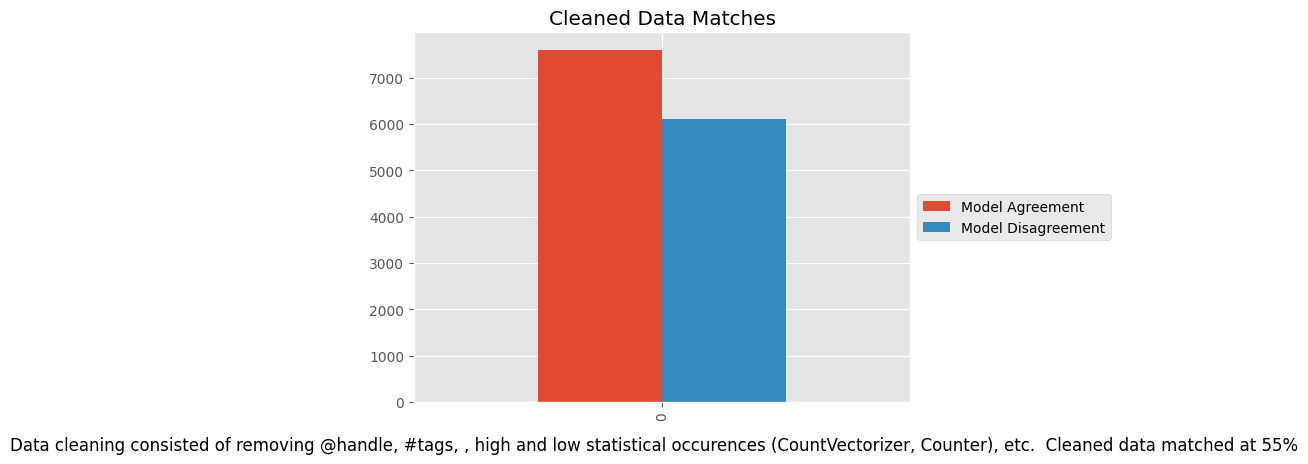

In [62]:
df4 = pd.DataFrame({"Model Agreement": [7596],"Model Disagreement": [6115],},columns=["Model Agreement", "Model Disagreement"])

df4.plot.bar()
plt.title('Cleaned Data Matches', color='black')
capt = "Data cleaning consisted of removing @handle, #tags, , high and low statistical occurences (CountVectorizer, Counter), etc.  Cleaned data matched at 55%" 
plt.figtext(0.5, 0.01, capt, wrap = True, horizontalalignment = 'center', fontsize = 12)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [63]:
# 012522:  Removing 'not' as stopword had a nominal reduction (<1%) reduction in the cleaned data matches; it actually reduced the matches

In [64]:
analyze_results.groupby(by=["noclean_match"]).count()

,tweet_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,vader_clean_class,vader_noclean_class,r_clean_format_label,r_noclean_label,roberta_class_clean,roberta_class_noclean,clean_match
noclean_match,,,,,,,,,,,,
False,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648
True,7063,7063,7063,7063,7063,7063,7063,7063,7063,7063,7063,7063


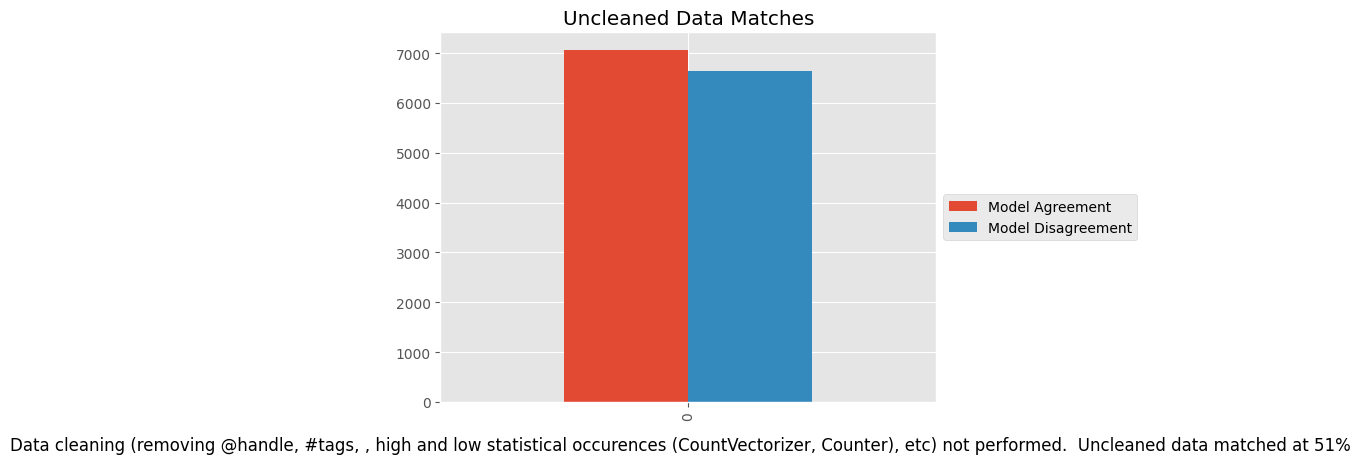

In [65]:
df5 = pd.DataFrame({"Model Agreement": [7063],"Model Disagreement": [6648],},columns=["Model Agreement", "Model Disagreement"])

df5.plot.bar()
plt.title('Uncleaned Data Matches', color='black')
capt = "Data cleaning (removing @handle, #tags, , high and low statistical occurences (CountVectorizer, Counter), etc) not performed.  Uncleaned data matched at 51%" 
plt.figtext(0.5, 0.01, capt, wrap = True, horizontalalignment = 'center', fontsize = 12)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Conclusions
1. Cleaning the data had an effect on each models performance as well as the concurrence ratio (4% intersection difference when comparing clean vs unclean data)
2. Not using a discrete 0 for NEUTRAL tag allowed for some flexibility in classification and improved model concurrence ratio by almost 4 points (-0.2499 < c < 0.2499)
3. Since the cleaned data had a higher intersection rate, the  cleaned data concurrence can potentially be used for a statistical trained approach for a training and test split

### Let's visually exam the cleaned data concurrence results

In [66]:
manual_exam = analyze_results[analyze_results['vader_clean_class']== analyze_results['roberta_class_clean']].sample(n=50)
manual_exam.reset_index(drop=True, inplace=True)
manual_exam.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 50 non-null     int64  
 1   text                     50 non-null     object 
 2   clean                    50 non-null     object 
 3   vader_sentiment_clean    50 non-null     float64
 4   vader_sentiment_noclean  50 non-null     float64
 5   vader_clean_class        50 non-null     int64  
 6   vader_noclean_class      50 non-null     int64  
 7   r_clean_format_label     50 non-null     object 
 8   r_noclean_label          50 non-null     object 
 9   roberta_class_clean      50 non-null     int64  
 10  roberta_class_noclean    50 non-null     int64  
 11  clean_match              50 non-null     bool   
 12  noclean_match            50 non-null     bool   
dtypes: bool(2), float64(2), int64(5), object(4)
memory usage: 4.5+ KB


In [67]:
manual_exam[['vader_clean_class','roberta_class_clean']].apply(pd.Series.value_counts)


,vader_clean_class,roberta_class_clean
1,27,27
0,17,17
2,6,6


In [68]:
# create function to print data about concurred values

In [69]:
def print_concur_values(i):
    print(manual_exam['text'].iloc[i])
    print("Vader classification is ", manual_exam['vader_clean_class'].iloc[i])
    print("Roberta classification is", manual_exam['roberta_class_clean'].iloc[i]) 

In [70]:
print_concur_values(0)

@sprintcare My phone has been 3g all morning. Here in KcK, KS. Never had this issue before. Rebooted and the problem persists.
Vader classification is  0
Roberta classification is 0


In [71]:
print_concur_values(1)

@sprintcare Go downtown broadway, anytime of day, and try to send a text. That’s why. -NM
Vader classification is  1
Roberta classification is 1


In [72]:
print_concur_values(2)

@sprintcare I thought you were slowing my data down, but then my neighbor asked do I have weak service bc she hasn't had reception lately.
Vader classification is  0
Roberta classification is 0


### From the looks of the predictions, the models both performed well to identify negative, positive and neutral sentiments
### Now let's see why the data that did not match differed in predictions

In [73]:
visual_exam_noconcur = analyze_results[analyze_results['vader_clean_class']!= analyze_results['roberta_class_clean']].sample(n=50)
visual_exam_noconcur.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 11600 to 12941
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 50 non-null     int64  
 1   text                     50 non-null     object 
 2   clean                    50 non-null     object 
 3   vader_sentiment_clean    50 non-null     float64
 4   vader_sentiment_noclean  50 non-null     float64
 5   vader_clean_class        50 non-null     int64  
 6   vader_noclean_class      50 non-null     int64  
 7   r_clean_format_label     50 non-null     object 
 8   r_noclean_label          50 non-null     object 
 9   roberta_class_clean      50 non-null     int64  
 10  roberta_class_noclean    50 non-null     int64  
 11  clean_match              50 non-null     bool   
 12  noclean_match            50 non-null     bool   
dtypes: bool(2), float64(2), int64(5), object(4)
memory usage: 4.8+ KB


In [74]:
manual_exam[['vader_noclean_class','roberta_class_noclean']].apply(pd.Series.value_counts)


,vader_noclean_class,roberta_class_noclean
0,17,24
1,27,22
2,6,4


In [75]:
def print_no_concur_values(i):
    print("\033[94m This is the cleaned data span:\n", visual_exam_noconcur['clean'].iloc[i])
    print("Vader classification - cleaned data", visual_exam_noconcur['vader_clean_class'].iloc[i])
    print("Roberta_classification - cleaned data", visual_exam_noconcur['roberta_class_clean'].iloc[i])
    print("\033[91m This is the uncleaned data span:\n", visual_exam_noconcur['text'].iloc[i])
    print("Vader classification - uncleaned data", visual_exam_noconcur['vader_noclean_class'].iloc[i])
    print("Roberta classification - uncleaned data", visual_exam_noconcur['roberta_class_noclean'].iloc[i])





In [76]:
print_no_concur_values(0)

 This is the cleaned data span:
 
Vader classification - cleaned data 1
Roberta_classification - cleaned data 2
 This is the uncleaned data span:
 @sprintcare #GTFOH
Vader classification - uncleaned data 1
Roberta classification - uncleaned data 0


In [77]:
print_no_concur_values(1)

 This is the cleaned data span:
 Hey how many times do call something removed from bill every month? Today will be 8th time I've called 8th credit will get. It's getting point can't handle being customer anymore. Time find new provider. You suck!
Vader classification - cleaned data 1
Roberta_classification - cleaned data 0
 This is the uncleaned data span:
 Hey @sprintcare how many times do I have to call to have something removed from my bill every month? Today will be the 8th time that I've called and the 8th credit I will get. It's getting to a point I can't handle being a customer anymore. Time to find a new provider. You suck!
Vader classification - uncleaned data 1
Roberta classification - uncleaned data 0


In [78]:
print_no_concur_values(2)

 This is the cleaned data span:
 great start morning! Getting hung up by cust rep &amp; not helping w/ an issue w/ them since AUGUST
Vader classification - cleaned data 2
Roberta_classification - cleaned data 0
 This is the uncleaned data span:
 @sprintcare great start to the morning! Getting hung up on by a cust rep &amp; not helping you w/ an issue you have w/ them since AUGUST
Vader classification - uncleaned data 2
Roberta classification - uncleaned data 0


In [79]:
print_no_concur_values(3)

 This is the cleaned data span:
 Yes did plan changed! This second time updated had account changed. would like corrected.
Vader classification - cleaned data 2
Roberta_classification - cleaned data 1
 This is the uncleaned data span:
 @sprintcare Yes I did and my plan was changed!  This is the second time I have updated a phone and had the account changed.  I would like it corrected.
Vader classification - uncleaned data 2
Roberta classification - uncleaned data 0


In [80]:
print_no_concur_values(4)

 This is the cleaned data span:
 no LTE
Vader classification - cleaned data 0
Roberta_classification - cleaned data 1
 This is the uncleaned data span:
 @sprintcare no LTE in 60169
Vader classification - uncleaned data 0
Roberta classification - uncleaned data 0


In [81]:
print_no_concur_values(5)

 This is the cleaned data span:
 less stolen by one employees they filed insurance claim. They still cell
Vader classification - cleaned data 0
Roberta_classification - cleaned data 1
 This is the uncleaned data span:
 @sprintcare less my phone was stolen by one your employees and they filed a insurance claim. They still obtain the cell phone
Vader classification - uncleaned data 0
Roberta classification - uncleaned data 0


In [82]:
print_no_concur_values(6)

 This is the cleaned data span:
 how do an account, pay, guys if "my number doesn't match any records?"
Vader classification - cleaned data 1
Roberta_classification - cleaned data 0
 This is the uncleaned data span:
 @sprintcare how do I have an account, pay, and service with you guys if "my number doesn't match any in your records?"
Vader classification - uncleaned data 1
Roberta classification - uncleaned data 0


In [83]:
print_no_concur_values(7)

 This is the cleaned data span:
 can't believe little brother getting from after coming back from basic training!
Vader classification - cleaned data 1
Roberta_classification - cleaned data 2
 This is the uncleaned data span:
 I can't believe the flack my little brother is getting from @115714 @sprintcare  after coming back from basic training!
Vader classification - uncleaned data 1
Roberta classification - uncleaned data 0


In [84]:
print_no_concur_values(8)

 This is the cleaned data span:
 My confirmation didn’t say day. Only it’s already shipped?? Can get before 3rd??
Vader classification - cleaned data 1
Roberta_classification - cleaned data 0
 This is the uncleaned data span:
 @578754 @115714 @sprintcare My confirmation didn’t say a day. Only that it’s already shipped?? Can you get it before the 3rd??
Vader classification - uncleaned data 1
Roberta classification - uncleaned data 1


In [85]:
print_no_concur_values(9)

 This is the cleaned data span:
 LTE still out 24 hours later. Think we can get tower issue taken care today?
Vader classification - cleaned data 2
Roberta_classification - cleaned data 0
 This is the uncleaned data span:
 @sprintcare LTE service still out 24 hours later. Think we can get this tower issue taken care of today?
Vader classification - uncleaned data 2
Roberta classification - uncleaned data 0


In [86]:
print_no_concur_values(10)

 This is the cleaned data span:
 Will do!
Vader classification - cleaned data 1
Roberta_classification - cleaned data 2
 This is the uncleaned data span:
 @sprintcare Will do!
Vader classification - uncleaned data 1
Roberta classification - uncleaned data 2


### From here, I am going to evaluate the actual scoring of the non-intersected data and identify performance of the models in the form of a confusion matrix
- 012523:  With the stopword change, the csv will be a new grouping

In [87]:
# send non-intersected data to csv for manipulation 
# dt.to_csv('file_name.csv',columns=['name'])
visual_exam_noconcur.to_csv('confusion_data_20220127', encoding='utf-16', columns = ['tweet_id', 'text', 'clean','vader_clean_class',
                                                          'roberta_class_clean'])


# Experimentation with Naives Bayes Classifier to test data quality

In [88]:
# create new dataframes for cleaned and uncleaned data for index items that are concurrent
uncleaned_concurrence = analyze_results[analyze_results['noclean_match']==True]
# uncleaned_concurrence.head(1)

In [89]:
# uncleaned_concurrence.drop(['clean','vader_sentiment_clean', 
#                          'vader_clean_class','r_clean_format_label', 
#                          'roberta_class_clean', 'r_noclean_label',
#                           'clean_match'], axis=1, inplace=True)

In [90]:
uncleaned_concurrence.reset_index(drop=True, inplace=True)

In [91]:
uncleaned_concurrence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7063 entries, 0 to 7062
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 7063 non-null   int64  
 1   text                     7063 non-null   object 
 2   clean                    7063 non-null   object 
 3   vader_sentiment_clean    7063 non-null   float64
 4   vader_sentiment_noclean  7063 non-null   float64
 5   vader_clean_class        7063 non-null   int64  
 6   vader_noclean_class      7063 non-null   int64  
 7   r_clean_format_label     7063 non-null   object 
 8   r_noclean_label          7063 non-null   object 
 9   roberta_class_clean      7063 non-null   int64  
 10  roberta_class_noclean    7063 non-null   int64  
 11  clean_match              7063 non-null   bool   
 12  noclean_match            7063 non-null   bool   
dtypes: bool(2), float64(2), int64(5), object(4)
memory usage: 620.9+ KB


In [93]:
uncleaned_concurrence.to_csv('twitter_dataset_noclean.csv')

In [94]:
uncleaned_concurrence.roberta_class_clean.value_counts()

0    3209
1    2824
2    1030
Name: roberta_class_clean, dtype: int64

In [95]:
cleaned_concurrence = analyze_results[analyze_results['clean_match']==True]

In [96]:
# cleaned_concurrence.drop(['clean','vader_sentiment_noclean', 
#                          'vader_noclean_class','r_clean_format_label', 
#                          'roberta_class_noclean', 'r_noclean_label',
#                           'noclean_match'], axis=1, inplace=True)

In [97]:
cleaned_concurrence.reset_index(drop=True, inplace=True)

In [98]:
cleaned_concurrence.head(1)

,tweet_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,vader_clean_class,vader_noclean_class,r_clean_format_label,r_noclean_label,roberta_class_clean,roberta_class_noclean,clean_match,noclean_match
0,1544038,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,negative,negative,0,0,True,True


In [99]:
cleaned_concurrence.to_csv('twitter_dataset_clean_20220127.csv')

In [100]:
cleaned_concurrence.roberta_class_clean.value_counts()

1    3409
0    3124
2    1063
Name: roberta_class_clean, dtype: int64

In [101]:
# cleaned_concurrence.info()

### Now that I have defined my "ground truth" labeled dataset as the intersection of inferences from my unsupervised methods, let's see if this can serve as a possible dataset for supervised (and therefore, more accurate) predictions.  One advantage of this approach is that for my training and test split, I will have the labels from Vader and Transformer to be able to evaluate the performance of the Supervised models.  

In [102]:
from nltk import FreqDist
# Important sklearn tools
from sklearn.feature_extraction.text import TfidfVectorizer
# this will be used to convert raw text to a matrix of TF-IDF features
from sklearn.pipeline import make_pipeline
# allows for automation in the workflows for the data transforms
# from sklearn.feature_selection import chi2
# # might use this for weeding out the features that are most likely to be independent of class
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# splits our training data into a n/m ratio in order to train our model
from sklearn.linear_model import LogisticRegression
# our standard classifier for multiclass classification problems
from sklearn.naive_bayes import MultinomialNB
# experimenting with a different NB model
from sklearn.naive_bayes import ComplementNB
# experiment with a NB model that is designed for imbalanced data sets
from sklearn.naive_bayes import BernoulliNB
# Bernoulli may perform better in our case due to the short nature of the documents (utterances)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# confusion matrix is used to help visualize the performance of a classification
from sklearn.metrics import accuracy_score, classification_report
# another scoring method, not sure if I'm going to finish with this
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### Start with the cleaned dataset, i.e., the set that I had a higher  concurrence intersection rate

#### As we can see below, there is a significant class imbalance, specifically with the Negative(0) and Positive (2) classes vs the Neutral class(1); I will have to determine which models and techniques to use to deal with this such as oversampling, SMOTE, etc

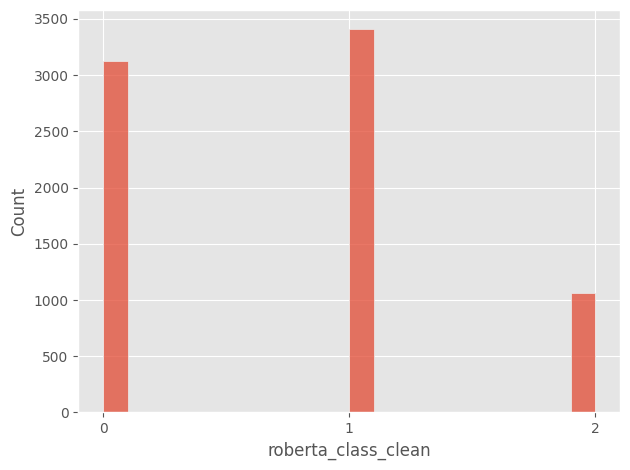

In [103]:

sns.histplot(data=cleaned_concurrence, x="roberta_class_clean")
plt.locator_params(axis="both", integer = True, tight = True)

plt.tight_layout()

In [104]:
# Positive, Neutral and Negative token patterns 
POS_WORDS = cleaned_concurrence[cleaned_concurrence.roberta_class_clean==2].clean.str.split().tolist()
POS_WORDS = [w for seq in POS_WORDS for w in seq]

NEU_WORDS = cleaned_concurrence[cleaned_concurrence.roberta_class_clean==1].clean.str.split().tolist()
NEU_WORDS = [w for seq in NEU_WORDS for w in seq]

NEG_WORDS = cleaned_concurrence[cleaned_concurrence.roberta_class_clean==0].clean.str.split().tolist()
NEG_WORDS = [w for seq in NEG_WORDS for w in seq]

In [105]:
len(POS_WORDS),len(NEU_WORDS), len(NEG_WORDS)

(9003, 26245, 45335)

In [106]:
# frequency distribution of Positive words
positive = FreqDist(POS_WORDS).most_common(10)
print (positive)

[('Thank', 177), ('Thanks', 103), ('be', 78), ('will', 68), ('so', 67), ('thanks', 64), ('good', 62), ('Yes', 60), ('you.', 58), ('just', 58)]


### ^^^ above we can see where case flipping, lemmatization might be a good idea

In [107]:
neutral=FreqDist(NEU_WORDS).most_common(10)
print(neutral)

[('be', 200), ('get', 197), ('can', 189), ('just', 188), ('do', 179), ('but', 178), ('iPhone', 160), ('an', 153), ('not', 146), ('will', 146)]


In [108]:
negative=FreqDist(NEG_WORDS).most_common(10)
print(negative)

[('no', 526), ('not', 413), ('customer', 311), ('been', 310), ('get', 287), ('just', 247), ('be', 240), ('are', 228), ('so', 226), ('but', 224)]


In [109]:
POS_DIST = pd.DataFrame(FreqDist(POS_WORDS).items(),columns =['word','WordCountPos'])
POS_DIST = POS_DIST.set_index('word')

NEU_DIST = pd.DataFrame(FreqDist(NEU_WORDS).items(), columns=['word', 'WordCountNeu'])
NEU_DIST = NEU_DIST.set_index('word')

NEG_DIST = pd.DataFrame(FreqDist(NEG_WORDS).items(),columns =['word','WordCountNeg'])
NEG_DIST = NEG_DIST.set_index('word')

In [110]:
COM_DIST = POS_DIST.merge(NEU_DIST, on = 'word').merge(NEG_DIST, on = 'word')

# COM_DIST = COM_DIST[(COM_DIST.WordCountPos + COM_DIST.WordCountNeu + COM_DIST.WordCountNeg)>50]
# COM_DIST['score'] = np.log(COM_DIST.WordCountPos / COM_DIST.WordCountNeg)

In [111]:
COM_DIST.head(10)

,WordCountPos,WordCountNeu,WordCountNeg
word,,,
Thanks,103,4,12
very,14,5,53
much,22,28,40
are,34,114,228
still,12,69,190
giving,3,1,8
out,29,104,127
am,27,72,145
Sprint,44,110,204


In [112]:
COM_DIST.tail(10)

,WordCountPos,WordCountNeu,WordCountNeg
word,,,
twitter,1,4,9
employee,1,6,11
have.,1,3,4
billing,1,5,20
now!,1,1,5
ready,1,3,3
somewhere,1,1,3
bet,1,1,5
Netflix,1,1,1


### Notes
1. We can see punctuation and caps.  Whereas the unsupervised models appeared to have dealt with this, our supervised model *might* require some additional text cleaning procedures
2. There are occurences of digits as well.  Probably will not be useful so I will eliminate those
3. The Proper Noun "Sprint" may not be useful here


#### Let's prepare our Training, Test and "Dev" set.  Dev set will will be 10% of the dataframe, randomly sampled that will be used for later purposes (to run as our final QA of the model, since we do have the classified values).  Training and Test will be randomly split 80/20 with the remainder

#### Since in my dataframe I only have concurrent predictions for both Vader and Roberta, I am going to use Roberta's predictions for the model classification of the training data

In [113]:
frac=0.1 # ten percent of the dataframe
dev_split = cleaned_concurrence.sample(frac=frac,random_state=42)
to_drop = dev_split.index

train_test = cleaned_concurrence.drop(to_drop)
#dev_range = default_rng().choice(cleaned_concurrence.index, size=665, replace=False)
#cleaned_concurrence.drop(index=dev_range)

In [114]:
train_test.reset_index(drop=True, inplace = True)

In [115]:
dev_split.reset_index(drop=True, inplace = True)

### Setting up the ML Training Pipeline

In [116]:
X = train_test['clean']
y = train_test['roberta_class_clean']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [117]:
print(X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print (X_test.shape, y_test.shape)

(5468,) (5468,)
(1368,) (1368,)
(1368,) (1368,)


### Use sklearn make_pipeline utility for automation and reusable code

In [118]:
automation = {
    "lr": make_pipeline(
        TfidfVectorizer(max_features=20000,
                        strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step
                        analyzer='word',            # Whether the feature should be made of word or character n-gram
                        token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'wor
                        ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracte
                        stop_words='english',
                        sublinear_tf=True),
        LogisticRegression()
    ),
    "mnb": make_pipeline(
        TfidfVectorizer(max_features=20000,
                        strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step
                        analyzer='word',            # Whether the feature should be made of word or character n-gram
                        token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'wor
                        ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracte
                        stop_words='english',
                        sublinear_tf=True),
        MultinomialNB()
    ),    
    "cnb": make_pipeline(
        TfidfVectorizer(max_features=20000,
                        strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step
                        analyzer='word',            # Whether the feature should be made of word or character n-gram
                        token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'wor
                        ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracte
                        stop_words='english',
                        sublinear_tf=True),
        ComplementNB()
        # experiment with the sklearn ComplementNB, which is designed to account for 
        # (cont'd) imbalanced data sets
    )
}

In [119]:
for p in tqdm(automation.values()):
    p.fit(X_train, y_train)

  0%|          | 0/3 [00:00<?, ?it/s]

In [120]:
for model_name, p in tqdm(automation.items()):
    print(model_name)
    y_pred_train = p.predict(X_train)
    print(classification_report(y_train, y_pred_train))

  0%|          | 0/3 [00:00<?, ?it/s]

lr
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2264
           1       0.92      0.97      0.94      2436
           2       0.98      0.76      0.86       768

    accuracy                           0.94      5468
   macro avg       0.95      0.90      0.92      5468
weighted avg       0.94      0.94      0.94      5468

mnb
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2264
           1       0.88      0.94      0.91      2436
           2       0.98      0.47      0.64       768

    accuracy                           0.88      5468
   macro avg       0.91      0.79      0.82      5468
weighted avg       0.89      0.88      0.87      5468

cnb
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2264
           1       0.96      0.89      0.92      2436
           2       0.96      0.95      0.95       768

    accur

#### ^^^ Now we can see that adjusting the valence measure as I described above had a very positive impact on the model training
####  Additionally, the CNB model, which is built to account for data imbalances, showed a very positive performance

In [121]:
for model_name, p in tqdm(automation.items()):
    print(model_name)
    y_pred_test = p.predict(X_test)
    print(classification_report(y_test, y_pred_test))
   

  0%|          | 0/3 [00:00<?, ?it/s]

lr
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       547
           1       0.82      0.82      0.82       641
           2       0.92      0.71      0.80       180

    accuracy                           0.81      1368
   macro avg       0.84      0.79      0.81      1368
weighted avg       0.81      0.81      0.81      1368

mnb
              precision    recall  f1-score   support

           0       0.67      0.84      0.75       547
           1       0.78      0.75      0.76       641
           2       0.94      0.36      0.52       180

    accuracy                           0.73      1368
   macro avg       0.80      0.65      0.68      1368
weighted avg       0.76      0.73      0.72      1368

cnb
              precision    recall  f1-score   support

           0       0.67      0.85      0.75       547
           1       0.80      0.64      0.71       641
           2       0.83      0.72      0.77       180

    accur

### In the above attempt using the 80/20 training/test split, the best performing model was the logistic regression model, with overall accuracy at 80%, but with the class performance for Classes 0, 1 and 2 being comparable.  Could this be because of class imbalance?  Let's take a further look into the performance of the LR(logistic regression) model, which did not perform as well as the CategoricalNB model in the training phase, but had better predictions on the test split

In [122]:
p_lr = automation["lr"]
p_lr.fit(X_train, y_train)
y_pred_train_lr = p_lr.predict(X_train)
print(classification_report(y_train, y_pred_train_lr))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2264
           1       0.92      0.97      0.94      2436
           2       0.98      0.76      0.86       768

    accuracy                           0.94      5468
   macro avg       0.95      0.90      0.92      5468
weighted avg       0.94      0.94      0.94      5468



              precision    recall  f1-score   support

           0       0.77      0.82      0.80       547
           1       0.82      0.82      0.82       641
           2       0.92      0.71      0.80       180

    accuracy                           0.81      1368
   macro avg       0.84      0.79      0.81      1368
weighted avg       0.81      0.81      0.81      1368

[[451  91   5]
 [108 527   6]
 [ 24  28 128]]
True Negatives =  451
False Negatives =  108
True Positives =  527
False Positives =  91


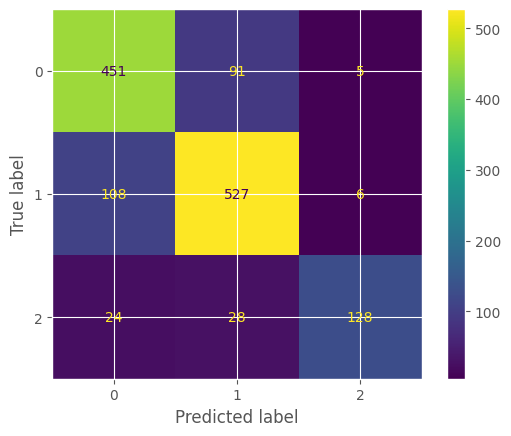

In [123]:
y_pred_test_lr = p_lr.predict(X_test)
print(classification_report(y_test, y_pred_test_lr))
cm = confusion_matrix(y_test, y_pred_test_lr, labels = p_lr.classes_)
print(cm)
print("True Negatives = ", cm[0][0])
print("False Negatives = ", cm[1][0])
print("True Positives = ", cm[1][1])
print("False Positives = ", cm[0][1])      
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=p_lr.classes_)
disp.plot()
plt.show()

In [124]:
p_cnb = automation["cnb"]
p_cnb.fit(X_train, y_train)
y_pred_train_cnb = p_cnb.predict(X_train)
print(classification_report(y_train, y_pred_train_lr))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2264
           1       0.92      0.97      0.94      2436
           2       0.98      0.76      0.86       768

    accuracy                           0.94      5468
   macro avg       0.95      0.90      0.92      5468
weighted avg       0.94      0.94      0.94      5468



              precision    recall  f1-score   support

           0       0.67      0.85      0.75       547
           1       0.80      0.64      0.71       641
           2       0.83      0.72      0.77       180

    accuracy                           0.74      1368
   macro avg       0.77      0.74      0.74      1368
weighted avg       0.75      0.74      0.74      1368

[[467  73   7]
 [210 411  20]
 [ 23  27 130]]
True Negatives =  467
False Negatives =  210
True Positives =  411
False Positives =  73


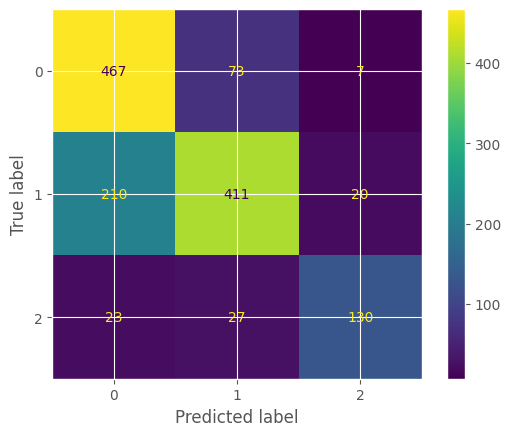

In [125]:
y_pred_test_cnb = p_cnb.predict(X_test)
print(classification_report(y_test, y_pred_test_cnb))
cm = confusion_matrix(y_test, y_pred_test_cnb, labels = p_cnb.classes_)
print(cm)
print("True Negatives = ", cm[0][0])
print("False Negatives = ", cm[1][0])
print("True Positives = ", cm[1][1])
print("False Positives = ", cm[0][1])      
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=p_cnb.classes_)
disp.plot()
plt.show()

###  Here, I am going to experiment with methods to alleviate classification imbalance.  It appears that we need to undersample the Neutral Class and potentially employ an combination of over- and under-sampling or ensemble method

In [126]:
class_count_1, class_count_0, class_count_2  = y_train.value_counts()
print("Negative", class_count_0, "Neutral", class_count_1, "Positive", class_count_2)
train_test['roberta_class_clean'].value_counts()

Negative 2264 Neutral 2436 Positive 768


1    3077
0    2811
2     948
Name: roberta_class_clean, dtype: int64

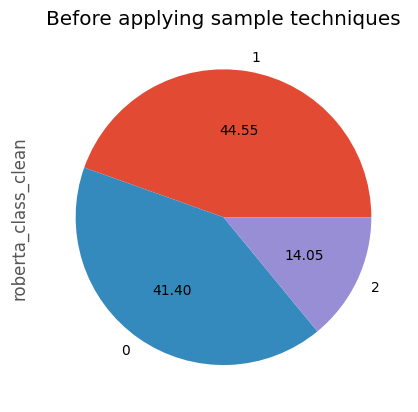

In [127]:
ax_imbalance = y_train.value_counts().plot.pie(autopct='%.2f')
_ = ax_imbalance.set_title("Before applying sample techniques")

### Run models indepdently to validate performance with sampling

In [128]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
# fit the predictor and target variable

In [129]:
# designate variables for testing with imbalances
X_os = train_test['clean']
y_os= train_test['roberta_class_clean']


In [130]:
# import pickle
td = TfidfVectorizer(
    max_features=20000,
    strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
    analyzer='word',            # Whether the feature should be made of word or character n-grams.
    token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'
    ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracted
    stop_words='english',
    sublinear_tf=True
)
# instead of the pipeline technique, I'm vectorizing the text data for sampling techniques
X_os = td.fit_transform(X_os).toarray()


In [131]:
print (X_os.shape)


(6836, 20000)


In [136]:
# train test split
Xos_train, Xos_test, yos_train, yos_test = train_test_split(X_os, y_os, test_size=0.2, random_state=50)

In [138]:
# Lets try RandomOverSampling
# Using SMOTE to deal with class imbalance.
counter= Counter(yos_train)
print('Before - ',counter)

sm= SMOTE()

Xos_train_sm, yos_train_sm = sm.fit_resample(Xos_train, yos_train)

counter= Counter(yos_train_sm)
print('After - ',counter)

Before -  Counter({1: 2436, 0: 2264, 2: 768})
After -  Counter({2: 2436, 1: 2436, 0: 2436})


In [141]:
logit = LogisticRegression(max_iter=400)
logit.fit(Xos_train_sm,yos_train_sm)

y_pred_train_sm= logit.predict(Xos_train_sm)

print('Training Accuracies after oversampling')
perf_report_lr_train = classification_report(yos_train_sm,y_pred_train_sm)
print(F'ACC : {accuracy_score(yos_train_sm,y_pred_train_sm)}')
print(perf_report_lr_train)



Training Accuracies after oversampling
ACC : 0.9470443349753694
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2436
           1       0.90      0.96      0.93      2436
           2       0.98      0.92      0.95      2436

    accuracy                           0.95      7308
   macro avg       0.95      0.95      0.95      7308
weighted avg       0.95      0.95      0.95      7308



#### Note above^^^ that the logistic regression model went from a nominal performance of this 

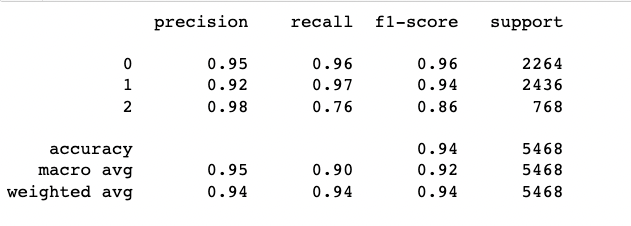

#### ^^^ oversampling seems to have improved the model performance in the trianing phase

### Run the test data against the model to evaluate performance with oversampling

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       547
           1       0.81      0.84      0.83       641
           2       0.83      0.79      0.81       180

    accuracy                           0.82      1368
   macro avg       0.82      0.81      0.81      1368
weighted avg       0.82      0.82      0.82      1368

[[433  99  15]
 [ 86 541  14]
 [ 12  26 142]]
True Negatives =  433
False Negatives =  86
True Positives =  541
False Positives =  99


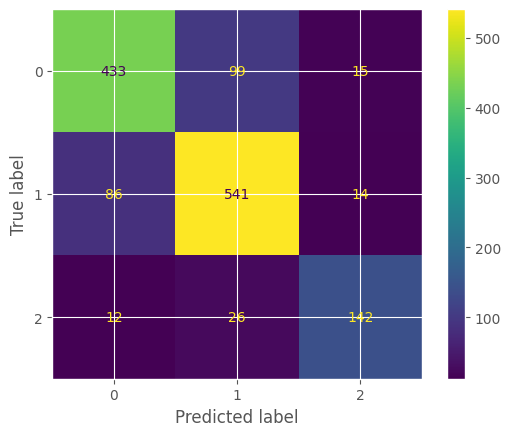

In [140]:
ysm_pred_test_logit = logit.predict(Xos_test)
print(classification_report(yos_test, ysm_pred_test_logit))
cm = confusion_matrix(yos_test, ysm_pred_test_logit, labels = logit.classes_)
print(cm)
print("True Negatives = ", cm[0][0])
print("False Negatives = ", cm[1][0])
print("True Positives = ", cm[1][1])
print("False Positives = ", cm[0][1])      
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logit.classes_)
disp.plot()
plt.show()






### One final test is to run the estimator with our dev split

In [134]:
# #Split our data into features(X) and labels(y) and use Random Undersampling
# X_rus = X_train
# y_rus = y_train
# # y_rus.value_counts()

In [135]:
# rus = RandomUnderSampler(sampling_strategy="majority") # Numerical value# Numerical value
# # rus = RandomUnderSampler(sampling_strategy="not minority") # String
# X_res, y_res = rus.fit_resample(X_rus, y_rus)
# ax = y_res.value_counts().plot.pie(autopct='%.2f')
# _ = ax.set_title("After under-sampling")
# print(y_res.value_counts())

### 20230125 Meeting with Shir follow-ups

- need to evaluate the ground truth based on model concurrence predictions
- need to build models as above for Vonage data